CODE BLOCK: 1

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [5]:
!pip install torchsummary

CODE BLOCK: 2

In [6]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [7]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [8]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 116135866.85it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 32899427.98it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32667277.87it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4549923.28it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 5

In [9]:
batch_size = 256

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

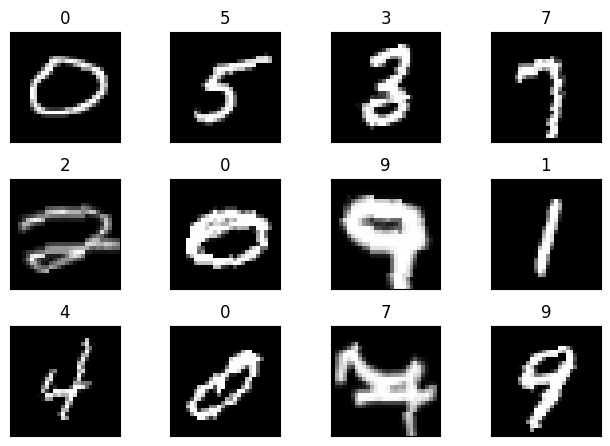

In [10]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(16)  # Batch normalization after the first convolutional layer
        self.conv2 = nn.Conv2d(16, 24, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(24)  # Batch normalization after the second convolutional layer
        self.conv2_1 = nn.Conv2d(24, 16, kernel_size=1)
        self.bn2_1 = nn.BatchNorm2d(16)  # Batch normalization after the second 1x1 convolutional layer
        self.conv3 = nn.Conv2d(16, 20, kernel_size=3, padding = 1)
        self.bn3 = nn.BatchNorm2d(20)  # Batch normalization after the third convolutional layer
        self.conv4 = nn.Conv2d(20, 25, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(25)  # Batch normalization after the fourth convolutional layer
        self.conv4_1 = nn.Conv2d(25, 19, kernel_size=1)
        self.bn4_1 = nn.BatchNorm2d(19)  # Batch normalization after the fourth 1x1 convolutional layer
        self.conv5 = nn.Conv2d(19, 29, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(29)
        self.conv6 = nn.Conv2d(29, 10, kernel_size=3)

        self.dropout = nn.Dropout2d(p=0.1)  # Minimal dropout with 10% probability

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # channel_size : 26, Receptive Field : 2
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))  #channel_size : 24, Receptive Field : 4
        x = self.dropout(x)
        x = F.max_pool2d(x, 2)  # channel_size : 12, Receptive Field : 5
        x = F.relu(self.bn2_1(self.conv2_1(x)))  # channel_size : 12, Receptive Field : 5
        x = F.relu(self.bn3(self.conv3(x)))  # channel_size : 12, Receptive Field : 9
        x = F.relu(self.bn4(self.conv4(x)))  # channel_size : 10, Receptive Field : 13
        x = F.max_pool2d(x, 2)  # channel_size : 5, Receptive Field : 15
        x = F.relu(self.bn4_1(self.conv4_1(x)))  # channel_size : 5, Receptive Field : 15
        x = F.relu(self.bn5(self.conv5(x)))# channel_size : 3, Receptive Field : 23
        x = self.conv6(x)# channel_size : 1, Receptive Field : 31

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)


In [14]:

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
         Dropout2d-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 24, 24, 24]           3,480
       BatchNorm2d-5           [-1, 24, 24, 24]              48
         Dropout2d-6           [-1, 24, 24, 24]               0
            Conv2d-7           [-1, 16, 12, 12]             400
       BatchNorm2d-8           [-1, 16, 12, 12]              32
            Conv2d-9           [-1, 20, 12, 12]           2,900
      BatchNorm2d-10           [-1, 20, 12, 12]              40
           Conv2d-11           [-1, 25, 10, 10]           4,525
      BatchNorm2d-12           [-1, 25, 10, 10]              50
           Conv2d-13             [-1, 19, 5, 5]             494
      BatchNorm2d-14             [-1, 1

CODE BLOCK: 8

In [15]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [16]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [17]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.1911 Batch_id=117 Accuracy=80.43: 100%|██████████| 118/118 [00:22<00:00,  5.16it/s]


Test set: Average loss: 0.1131, Accuracy: 9725/10000 (97.25%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1489 Batch_id=117 Accuracy=95.96: 100%|██████████| 118/118 [00:23<00:00,  5.09it/s]


Test set: Average loss: 0.0645, Accuracy: 9809/10000 (98.09%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0677 Batch_id=117 Accuracy=97.22: 100%|██████████| 118/118 [00:23<00:00,  5.02it/s]


Test set: Average loss: 0.0448, Accuracy: 9860/10000 (98.60%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0632 Batch_id=117 Accuracy=97.65: 100%|██████████| 118/118 [00:23<00:00,  5.02it/s]


Test set: Average loss: 0.0381, Accuracy: 9884/10000 (98.84%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.1050 Batch_id=117 Accuracy=97.93: 100%|██████████| 118/118 [00:23<00:00,  4.98it/s]


Test set: Average loss: 0.0325, Accuracy: 9904/10000 (99.04%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0448 Batch_id=117 Accuracy=98.09: 100%|██████████| 118/118 [00:23<00:00,  4.94it/s]


Test set: Average loss: 0.0276, Accuracy: 9917/10000 (99.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0178 Batch_id=117 Accuracy=98.36: 100%|██████████| 118/118 [00:23<00:00,  4.95it/s]


Test set: Average loss: 0.0265, Accuracy: 9913/10000 (99.13%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0548 Batch_id=117 Accuracy=98.39: 100%|██████████| 118/118 [00:23<00:00,  4.95it/s]


Test set: Average loss: 0.0245, Accuracy: 9928/10000 (99.28%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0370 Batch_id=117 Accuracy=98.57: 100%|██████████| 118/118 [00:23<00:00,  5.03it/s]


Test set: Average loss: 0.0233, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.1133 Batch_id=117 Accuracy=98.67: 100%|██████████| 118/118 [00:24<00:00,  4.81it/s]


Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0627 Batch_id=117 Accuracy=98.68: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


Test set: Average loss: 0.0211, Accuracy: 9937/10000 (99.37%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0043 Batch_id=117 Accuracy=98.74: 100%|██████████| 118/118 [00:24<00:00,  4.91it/s]


Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0152 Batch_id=117 Accuracy=98.77: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


Test set: Average loss: 0.0201, Accuracy: 9935/10000 (99.35%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0880 Batch_id=117 Accuracy=98.78: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


Test set: Average loss: 0.0189, Accuracy: 9941/10000 (99.41%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0678 Batch_id=117 Accuracy=98.84: 100%|██████████| 118/118 [00:24<00:00,  4.88it/s]


Test set: Average loss: 0.0189, Accuracy: 9945/10000 (99.45%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0117 Batch_id=117 Accuracy=98.94: 100%|██████████| 118/118 [00:24<00:00,  4.88it/s]


Test set: Average loss: 0.0174, Accuracy: 9947/10000 (99.47%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0162 Batch_id=117 Accuracy=99.03: 100%|██████████| 118/118 [00:24<00:00,  4.81it/s]


Test set: Average loss: 0.0172, Accuracy: 9946/10000 (99.46%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0481 Batch_id=117 Accuracy=98.96: 100%|██████████| 118/118 [00:24<00:00,  4.84it/s]


Test set: Average loss: 0.0170, Accuracy: 9947/10000 (99.47%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0337 Batch_id=117 Accuracy=99.00: 100%|██████████| 118/118 [00:24<00:00,  4.80it/s]


Test set: Average loss: 0.0167, Accuracy: 9949/10000 (99.49%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0286 Batch_id=117 Accuracy=99.04: 100%|██████████| 118/118 [00:24<00:00,  4.84it/s]


Test set: Average loss: 0.0164, Accuracy: 9952/10000 (99.52%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

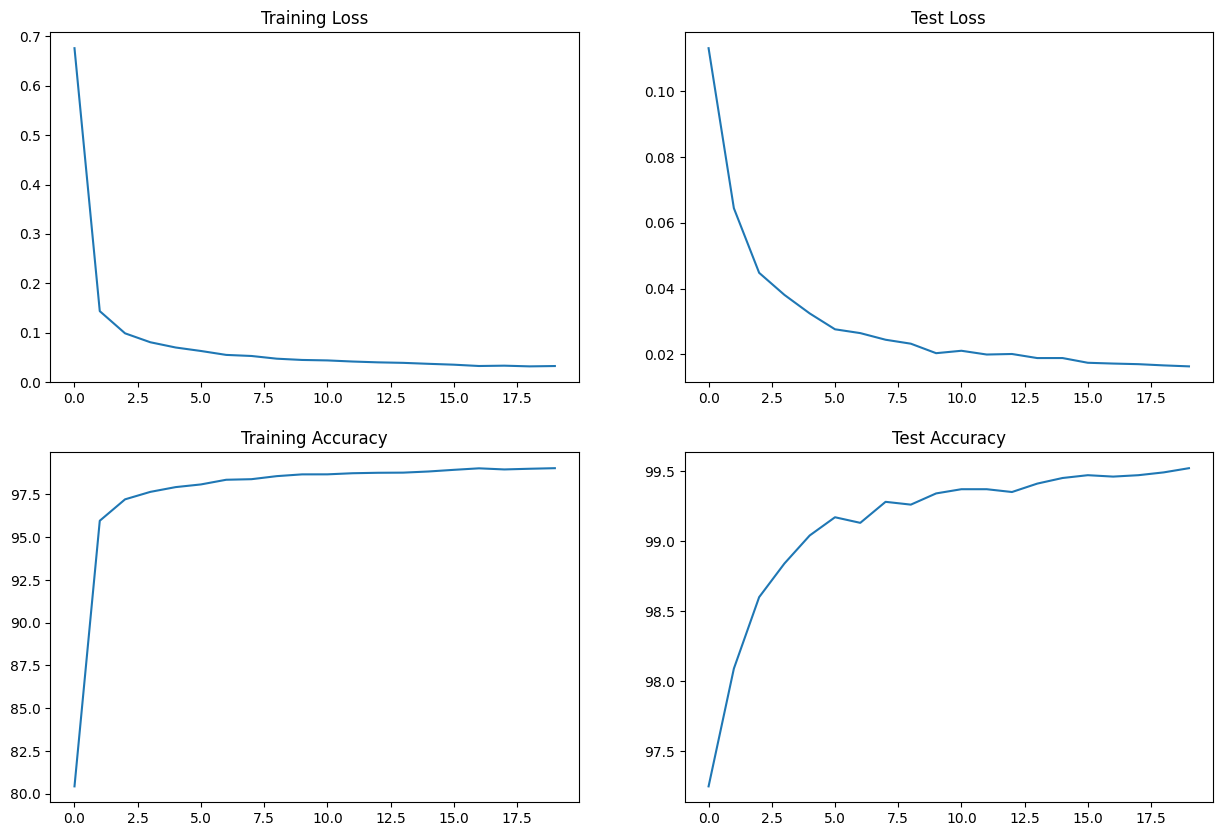

In [20]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [21]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
         Dropout2d-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 24, 24, 24]           3,480
       BatchNorm2d-5           [-1, 24, 24, 24]              48
         Dropout2d-6           [-1, 24, 24, 24]               0
            Conv2d-7           [-1, 16, 12, 12]             400
       BatchNorm2d-8           [-1, 16, 12, 12]              32
            Conv2d-9           [-1, 20, 12, 12]           2,900
      BatchNorm2d-10           [-1, 20, 12, 12]              40
           Conv2d-11           [-1, 25, 10, 10]           4,525
      BatchNorm2d-12           [-1, 25, 10, 10]              50
           Conv2d-13             [-1, 19, 5, 5]             494
      BatchNorm2d-14             [-1, 1